# Raman Molmer-Sorensen


## Atomic Circuit


In [ ]:
import numpy as np
from oqd_core.interface.atomic import (  # noqa: F401
    AtomicCircuit,
    Beam,
    ParallelProtocol,
    Phonon,
    Pulse,
    System,
    Yb171IIBuilder,
)

N = 4
ions = [Yb171IIBuilder().build(["q0", "q1", "e1m"]) for _ in range(N)]
COM_x = Phonon(
    energy=2 * np.pi * 1e6, eigenvector=sum([[1 / np.sqrt(N), 0, 0] * N], [])
)
system = System(ions=ions, modes=[COM_x])

beams = []
for i in range(N):
    beams.extend(
        [
            Beam(
                transition="q0->e1m",
                rabi=np.sqrt(2) * 2 * np.pi * 1e9,
                detuning=2 * np.pi * 33.195e12,
                phase=0,
                polarization=[0, 1, 0],
                wavevector=[-1, 0, 0],
                target=i,
            ),
            Beam(
                transition="q1->e1m",
                rabi=2 * np.pi * 1e9,
                detuning=2 * np.pi * (33.195e12 - 1.01e6),
                phase=0,
                polarization=[0, 1, 0],
                wavevector=[1, 0, 0],
                target=i,
            ),
            Beam(
                transition="q1->e1m",
                rabi=2 * np.pi * 1e9,
                detuning=2 * np.pi * (33.195e12 + 1.01e6),
                phase=0,
                polarization=[0, 1, 0],
                wavevector=[1, 0, 0],
                target=i,
            ),
        ]
    )

protocol = ParallelProtocol(
    sequence=[Pulse(beam=beam, duration=4e-3) for beam in beams]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [2]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("5_ising.json", "w") as f:
    f.write(circuit_json)

In [3]:
with open("5_ising.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


### Compile


In [4]:
from oqd_compiler_infrastructure import Chain, Post

from oqd_trical.backend import DynamiqsBackend, QutipBackend  # noqa: F401
from oqd_trical.light_matter.compiler.approximate import (
    FirstOrderLambDickeApprox,  # noqa: F401
    RotatingReferenceFrame,
    RotatingWaveApprox,
    SecondOrderLambDickeApprox,  # noqa: F401
    adiabatic_elimination_factory,
)
from oqd_trical.light_matter.compiler.canonicalize import (
    canonicalize_emulator_circuit_factory,
)

frame_specs = {
    f"E{i}": [
        ions[i].levels[0].energy,
        ions[i].levels[1].energy,
        2 * np.pi * 33.195e12 + ions[i].levels[2].energy,
    ]
    for i in range(N)
}
frame_specs["P0"] = 2 * np.pi * 1e6

eliminated_specs = [(2, f"E{i}") for i in range(N)]

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalize_emulator_circuit_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 1e9)),
    canonicalize_emulator_circuit_factory(),
    adiabatic_elimination_factory(eliminated_specs=eliminated_specs),
    canonicalize_emulator_circuit_factory(),
    Post(FirstOrderLambDickeApprox(0.1)),
)

backend = QutipBackend(approx_pass=approx_pass)

fock_cutoff = 3
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

D:\work\Projects\TrICal\src\oqd_trical\light_matter\compiler\approximate.py:424: UserWarning: Caution required when using adiabatic elimination, system needs to be put in the appropriate rotating reference frame.
  warnings.warn(


In [5]:
from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(hilbert_space), "=" * 80, printer(backend.intermediate), sep="\n")

HilbertSpace
  - hilbert_space: dict
    - E0: set({0, 1})
    - E1: set({0, 1})
    - E2: set({0, 1})
    - E3: set({0, 1})
    - P0: set({0, 1, 2})
AtomicEmulatorCircuit
  - frame: Operator(79437055201.61006 * |1><1|_E0 @ I_E1 @ I_E2 @ I_E3 @ I_P0 + 79437055201.61006 * I_E0 @ |1><1|_E1 @ I_E2 @ I_E3 @ I_P0 + 79437055201.61006 * I_E0 @ I_E1 @ |1><1|_E2 @ I_E3 @ I_P0 + 79437055201.61006 * I_E0 @ I_E1 @ I_E2 @ |1><1|_E3 @ I_P0 + 6283185.307179586 * I_E0 @ I_E1 @ I_E2 @ I_E3 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(94640.53783972889 * |0><0|_E0 @ I_E1 @ I_E2 @ I_E3 @ I_P0 + (-2277.0197558742893 * exp(1j * (6283185.307179586 * t + -1.5707963267948966)) + -2277.0197558742893 * exp(1j * (6283185.307179586 * t + 1.5707963267948966))) * |0><0|_E0 @ I_E1 @ I_E2 @ I_E3 @ C_P0 + (2277.0197558742893 * exp(1j * (-6283185.307179586 * t + -1.5707963267948966)) + 2277.0197558742893 * exp(1j * (-6283185.307179586 * t + 1.5707963267948966))) * |0><0|_E

### Run


In [6]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-5,
)

10.0%. Run time:   7.36s. Est. time left: 00:00:01:06
20.0%. Run time:  14.77s. Est. time left: 00:00:00:59
30.0%. Run time:  22.01s. Est. time left: 00:00:00:51
40.0%. Run time:  29.27s. Est. time left: 00:00:00:43
50.0%. Run time:  36.51s. Est. time left: 00:00:00:36
60.0%. Run time:  43.85s. Est. time left: 00:00:00:29
70.0%. Run time:  50.65s. Est. time left: 00:00:00:21
80.0%. Run time:  57.98s. Est. time left: 00:00:00:14
90.0%. Run time:  65.70s. Est. time left: 00:00:00:07
100.0%. Run time:  73.30s. Est. time left: 00:00:00:00
Total run time:  73.30s


#### Results


In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

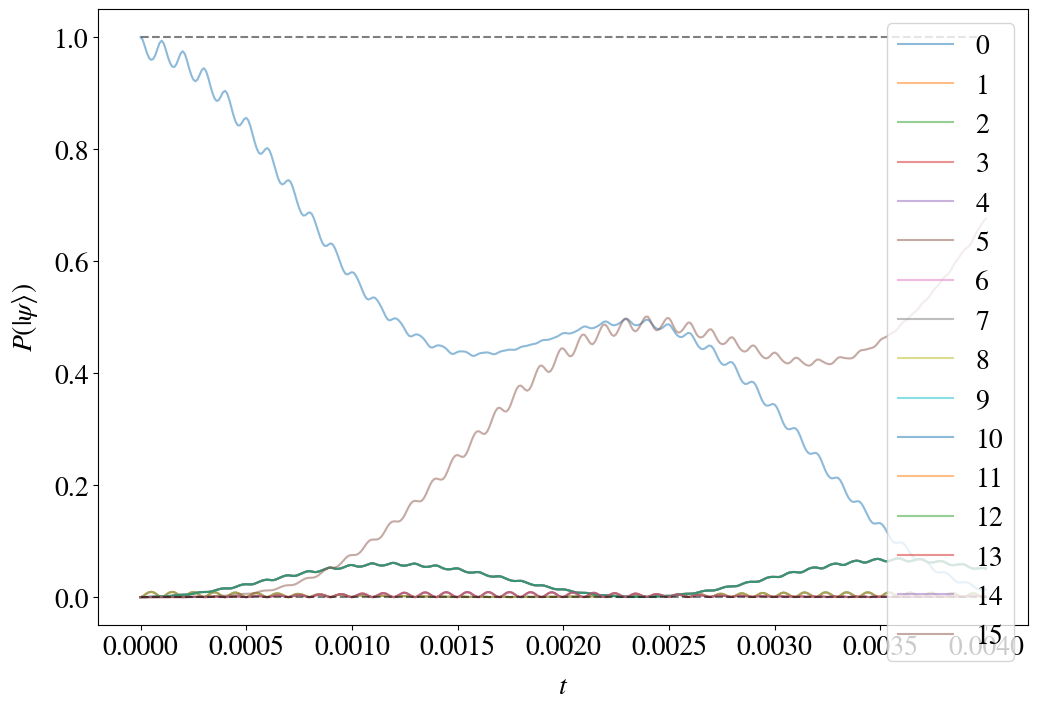

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)


state_labels = range(2**N)
plot_states = [
    [s.ptrace(range(N)).diag()[i] for i in state_labels] for s in result["states"][k]
]

ax.plot(result["tspan"][k], plot_states, label=range(len(state_labels)), alpha=0.5)

ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

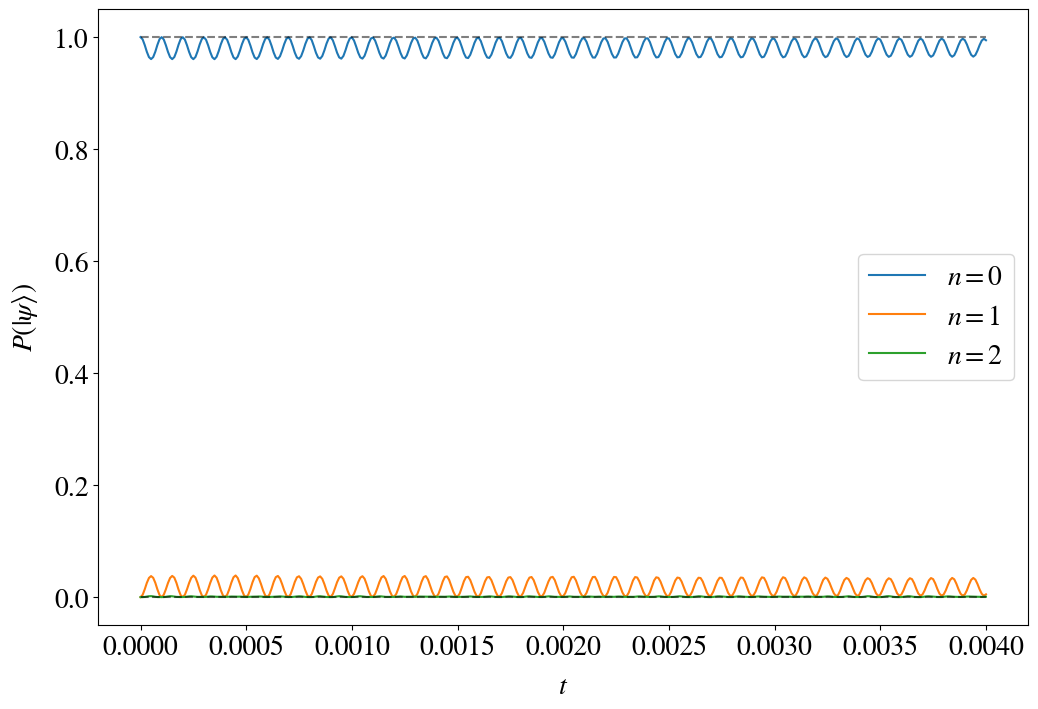

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(N).diag()[:] for s in result["states"][k]],
    label=[rf"$n={n}$" for n in range(fock_cutoff)],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()